In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import re

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [4]:
import collections
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [6]:
train = pd.read_json('snli_1.0_train.jsonl', lines = True)
test = pd.read_json('snli_1.0_test.jsonl', lines = True)
val = pd.read_json('snli_1.0_dev.jsonl', lines = True)
full = {'train': train, 'val':val, 'test': test}

In [7]:
def delete_unsure_labels(data):
    data = data.drop(index = data[data.gold_label == '-'].index)
    return data


for frame in full:
    full[frame] = delete_unsure_labels(full[frame])

In [8]:
train = full['train']
val = full['val']
test = full['test']

Добавляем столбцы с постэгами

In [66]:
def PoS(data):
    data['PoS_1'] = data['sentence1_parse'].apply(lambda x: re.findall('\((\w+) \w+\)', x))
    data['PoS_2'] = data['sentence2_parse'].apply(lambda x: re.findall('\((\w+) \w+\)', x))

In [67]:
PoS(val)
PoS(train)
PoS(test)

In [68]:
train

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse,sentence1_lemmas,sentence2_lemmas,sentence1_len,sentence2_len,PoS_1,PoS_2
0,[neutral],3416050480.jpg#4,neutral,3416050480.jpg#4r1n,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,A person is training his horse for a competition.,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,"[a, person, on, a, horse, jumps, over, a, brok...","[a, person, is, training, his, horse, for, a, ...",11,9,"[DT, NN, IN, DT, NN, VBZ, IN, DT, JJ, JJ, NN]","[DT, NN, VBZ, VBG, NN, IN, DT, NN]"
1,[contradiction],3416050480.jpg#4,contradiction,3416050480.jpg#4r1c,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,"A person is at a diner, ordering an omelette.",( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,"[a, person, on, a, horse, jumps, over, a, brok...","[a, person, is, at, a, diner, ordering, an, om...",11,9,"[DT, NN, IN, DT, NN, VBZ, IN, DT, JJ, JJ, NN]","[DT, NN, VBZ, IN, DT, NN, VBG, DT, NN]"
2,[entailment],3416050480.jpg#4,entailment,3416050480.jpg#4r1e,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,"A person is outdoors, on a horse.","( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,"[a, person, on, a, horse, jumps, over, a, brok...","[a, person, is, outdoors, on, a, horse]",11,7,"[DT, NN, IN, DT, NN, VBZ, IN, DT, JJ, JJ, NN]","[DT, NN, VBZ, RB, IN, DT, NN]"
3,[neutral],2267923837.jpg#2,neutral,2267923837.jpg#2r1n,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at c...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,They are smiling at their parents,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,"[children, smiling, and, waving, at, camera]","[they, are, smiling, at, their, parents]",6,6,"[NNP, VBG, CC, VBG, IN, NN]","[PRP, VBP, VBG, IN, NNS]"
4,[entailment],2267923837.jpg#2,entailment,2267923837.jpg#2r1e,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at c...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,There are children present,( There ( ( are children ) present ) ),(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,"[children, smiling, and, waving, at, camera]","[there, are, children, present]",6,4,"[NNP, VBG, CC, VBG, IN, NN]","[EX, VBP, NNS, RB]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550147,[contradiction],2267923837.jpg#3,contradiction,2267923837.jpg#3r1c,Four dirty and barefooted children.,( ( ( ( Four dirty ) and ) ( barefooted childr...,(ROOT (NP (NP (CD Four) (NNS dirty)) (CC and) ...,four kids won awards for 'cleanest feet',( ( four kids ) ( ( won awards ) ( ( ( for ` )...,(ROOT (S (NP (CD four) (NNS kids)) (VP (VBD wo...,"[four, dirty, and, barefooted, children]","[four, kids, won, awards, for, cleanest, feet]",5,7,"[CD, NNS, CC, VBN, NNS]","[CD, NNS, VBD, NNS, IN, JJ, NNS]"
550148,[neutral],2267923837.jpg#3,neutral,2267923837.jpg#3r1n,Four dirty and barefooted children.,( ( ( ( Four dirty ) and ) ( barefooted childr...,(ROOT (NP (NP (CD Four) (NNS dirty)) (CC and) ...,"four homeless children had their shoes stolen,...",( ( ( ( ( ( four ( homeless children ) ) ( had...,(ROOT (S (S (NP (CD four) (JJ homeless) (NNS c...,"[four, dirty, and, barefooted, children]","[four, homeless, children, had, their, shoes, ...",5,12,"[CD, NNS, CC, VBN, NNS]","[CD, JJ, NNS, VBD, NNS, VBN, IN, NNS, VBP, JJ]"
550149,[neutral],7979219683.jpg#2,neutral,7979219683.jpg#2r1n,A man is surfing in a bodysuit in beauti

Добавляем столбцы с леммами и количеством токенов

In [9]:
def add_lemmas(data):
    data['sentence1_lemmas'] = data['sentence1'].apply(lambda x: tokenizer.tokenize(x.lower()))
    data['sentence2_lemmas'] = data['sentence2'].apply(lambda x: tokenizer.tokenize(x.lower()))
    data['sentence1_len'] = data['sentence1_lemmas'].apply(lambda x: len(x))
    data['sentence2_len'] = data['sentence2_lemmas'].apply(lambda x: len(x))

In [10]:
add_lemmas(train)
add_lemmas(val)
add_lemmas(test)

Смотрим на распределение количества токенов

In [15]:
df2 = train[['gold_label', 'sentence1_len', 'sentence2_len']].append(val[['gold_label', 'sentence1_len', 'sentence2_len']]).append(test[['gold_label', 'sentence1_len', 'sentence2_len']])

In [16]:
df3 = df2[['gold_label', 'sentence1_len']].rename(columns={'gold_label': 'label', 'sentence1_len': 'len'})
df3['sentence'] = pd.DataFrame([1 for i in range(len(df3))])
df4 = df2[['gold_label', 'sentence2_len']].rename(columns={'gold_label': 'label', 'sentence2_len': 'len'})
df4['sentence'] = pd.DataFrame([2 for i in range(len(df4))])
df5 = df3.append(df4)
df5

,label,len,sentence
0,neutral,11,1
1,contradiction,11,1
2,entailment,11,1
3,neutral,6,1
4,entailment,6,1
...,...,...,...
9995,contradiction,8,2
9996,entailment,6,2
9997,contradiction,6,2
9998,entailment,7,2


In [26]:
df5 = df5.rename(columns={'len': 'tokens'})

In [27]:
df5

,label,tokens,sentence
0,neutral,11,1
1,contradiction,11,1
2,entailment,11,1
3,neutral,6,1
4,entailment,6,1
...,...,...,...
9995,contradiction,8,2
9996,entailment,6,2
9997,contradiction,6,2
9998,entailment,7,2


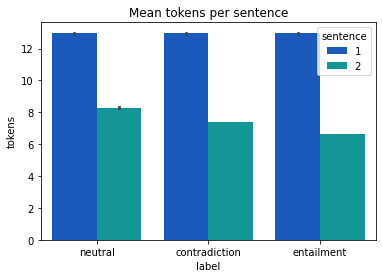

In [64]:
sns.barplot(x="label", y="tokens", hue='sentence', data=df5, palette='winter')
plt.title('Mean tokens per sentence');

Составляем частотные словари лемм и постэгов

In [20]:
def count_freq(data, di):
    for ind, row in data.iterrows():
        for lemma in row['sentence1_lemmas']:
            if lemma not in stopwords.words('english'):
                di['1'][row['gold_label']][lemma] += 1
        for lemma in row['sentence2_lemmas']:
            if lemma not in stopwords.words('english'):
                di['2'][row['gold_label']][lemma] += 1

In [83]:
def count_pos(data, di):
    for ind, row in data.iterrows():
        for PoS in row['PoS_1']:
            di['1'][row['gold_label']][PoS] += 1
        for PoS in row['PoS_2']:
            di['2'][row['gold_label']][PoS] += 1

In [84]:
data_pos = {'1': {'contradiction': collections.Counter(), 'entailment': collections.Counter(), 'neutral': collections.Counter()}, 
             '2': {'contradiction': collections.Counter(), 'entailment': collections.Counter(), 'neutral': collections.Counter()}}
count_pos(train, data_pos)
count_pos(test, data_pos)
count_pos(val, data_pos)

In [38]:
data_freq = {'1': {'contradiction': collections.Counter(), 'entailment': collections.Counter(), 'neutral': collections.Counter()}, 
             '2': {'contradiction': collections.Counter(), 'entailment': collections.Counter(), 'neutral': collections.Counter()}}
count_freq(train, data_freq)
count_freq(test, data_freq)
count_freq(val, data_freq)

KeyboardInterrupt: 

In [30]:
for link in ['contradiction', 'entailment', 'neutral']:
    for i in ['1', '2']:
        data_freq[i][link] = data_freq[i][link].most_common(10)

In [31]:
data_freq

{'1': {'contradiction': [('man', 52550),
   ('woman', 27352),
   ('two', 26151),
   ('wearing', 20872),
   ('people', 20740),
   ('shirt', 19065),
   ('white', 17421),
   ('black', 16346),
   ('young', 16172),
   ('blue', 14959)],
  'entailment': [('man', 52651),
   ('woman', 27365),
   ('two', 26267),
   ('wearing', 20953),
   ('people', 20770),
   ('shirt', 19100),
   ('white', 17428),
   ('black', 16388),
   ('young', 16224),
   ('blue', 14984)],
  'neutral': [('man', 52405),
   ('woman', 27356),
   ('two', 26058),
   ('wearing', 20874),
   ('people', 20821),
   ('shirt', 19027),
   ('white', 17364),
   ('black', 16269),
   ('young', 16144),
   ('blue', 14915)]},
 '2': {'contradiction': [('man', 40507),
   ('woman', 22412),
   ('people', 17479),
   ('two', 15583),
   ('playing', 10359),
   ('sitting', 10318),
   ('men', 10105),
   ('girl', 9306),
   ('boy', 8961),
   ('dog', 8488)],
  'entailment': [('man', 38892),
   ('people', 27671),
   ('woman', 19140),
   ('two', 17736),
   ('o

In [32]:
data_words = pd.DataFrame(data_freq)

In [33]:
data_words

,1,2
contradiction,"[(man, 52550), (woman, 27352), (two, 26151), (...","[(man, 40507), (woman, 22412), (people, 17479)..."
entailment,"[(man, 52651), (woman, 27365), (two, 26267), (...","[(man, 38892), (people, 27671), (woman, 19140)..."
neutral,"[(man, 52405), (woman, 27356), (two, 26058), (...","[(man, 39217), (woman, 19230), (people, 17920)..."


In [43]:
dict(data_words['1']['contradiction'])

{'man': 52550,
 'woman': 27352,
 'two': 26151,
 'wearing': 20872,
 'people': 20740,
 'shirt': 19065,
 'white': 17421,
 'black': 16346,
 'young': 16172,
 'blue': 14959}

In [ ]:
data_freq_1 = {'1': {'contradiction': {}, 'entailment': {}, 'neutral': {}}, 
             '2': {'contradiction': {}, 'entailment': {}, 'neutral': {}}}

In [44]:
data_freq_1 = {'1': {'contradiction': {}, 'entailment': {}, 'neutral': {}}, 
             '2': {'contradiction': {}, 'entailment': {}, 'neutral': {}}}
for link in ['contradiction', 'entailment', 'neutral']:
    for i in ['1', '2']:
        #data_freq[i][link] = data_freq[i][link].most_common(10)
        data_freq_1[i][link] = dict(data_words[i][link])

In [49]:
df6 = pd.DataFrame(data_freq_1['1'])

In [50]:
df7 = pd.DataFrame(data_freq_1['2'])

In [53]:
df6['contradiction']['man']

52550

In [54]:
w = {'label': [], 'word': [], 'total': []}
for label in ['contradiction', 'entailment', 'neutral']:
    for word in df6.index:
        w['label'].append(label)
        w['word'].append(word)
        w['total'].append(df6[label][word])

In [57]:
df8 = pd.DataFrame(w)

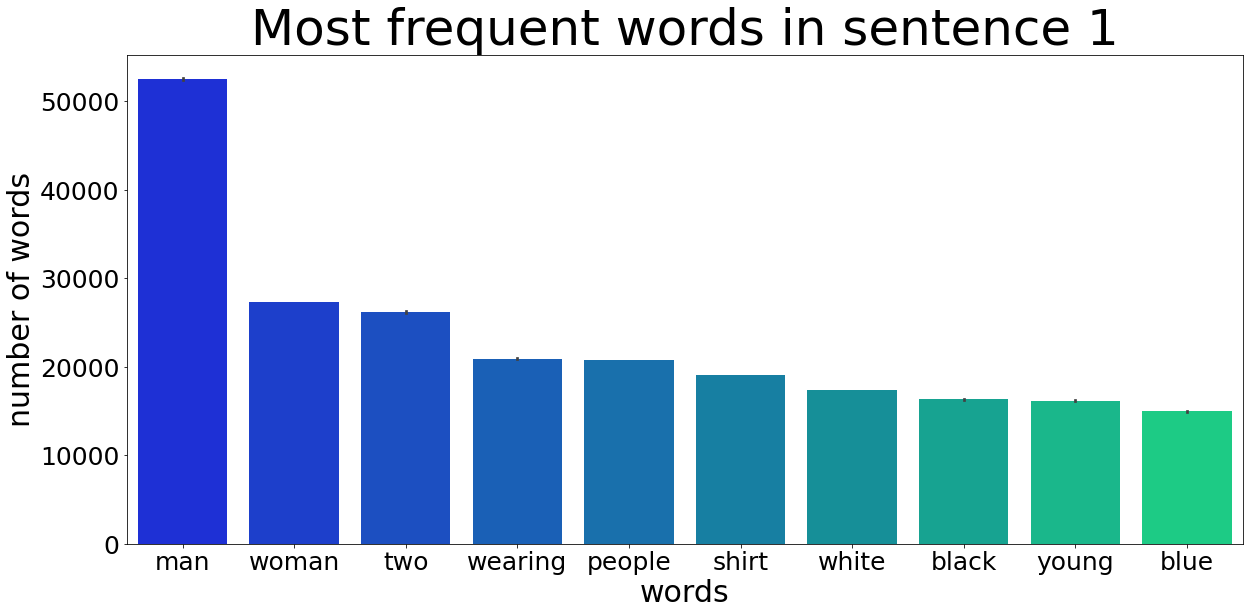

In [78]:
plt.figure(figsize=(20, 9))
ax = sns.barplot(x="word", y="total", data=df8, palette='winter')
ax.set_xlabel("words",fontsize=30)
ax.set_ylabel("number of words",fontsize=30)
ax.tick_params(labelsize=25)
plt.title('Most frequent words in sentence 1', fontsize=50);

In [62]:
w_1 = {'label': [], 'word': [], 'total': []}
for label in ['contradiction', 'entailment', 'neutral']:
    for word in df7.index:
        w_1['label'].append(label)
        w_1['word'].append(word)
        w_1['total'].append(df7[label][word])

df9 = pd.DataFrame(w_1)

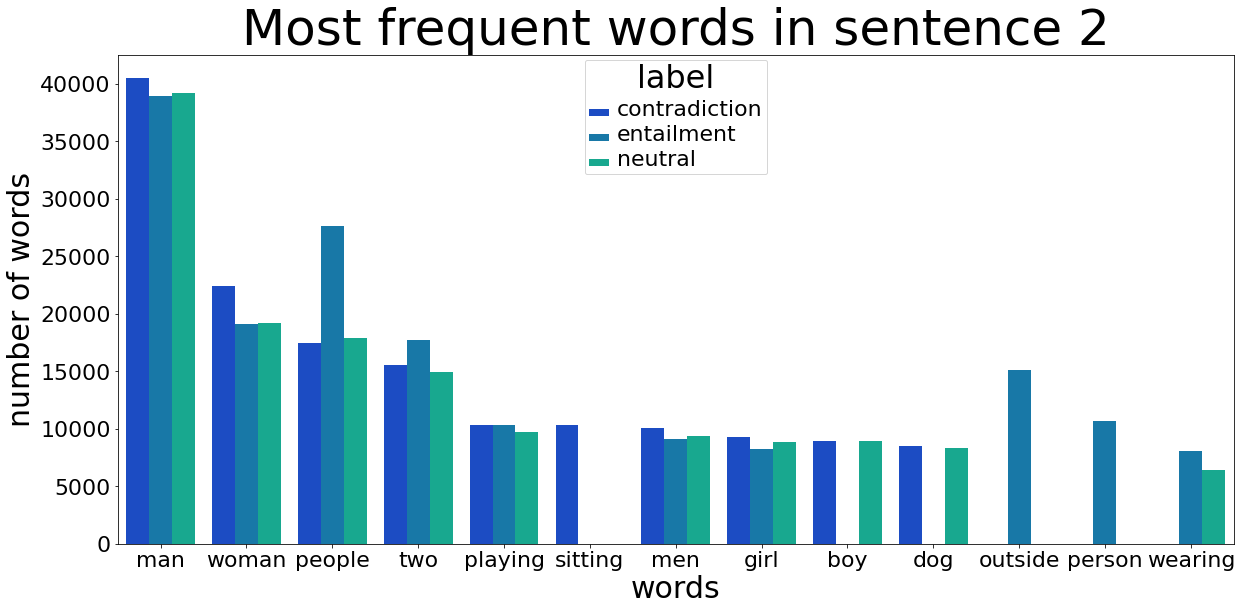

In [80]:
plt.figure(figsize=(20, 9))
ax = sns.barplot(x="word", y="total", hue='label', data=df9, palette='winter')
ax.set_xlabel("words",fontsize=30)
ax.set_ylabel("number of words",fontsize=30)
ax.tick_params(labelsize=22)
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
plt.title('Most frequent words in sentence 2', fontsize=50);


In [85]:
data_pos

{'1': {'contradiction': Counter({'DT': 450884,
           'NN': 615832,
           'IN': 362453,
           'VBZ': 103768,
           'JJ': 224224,
           'NNP': 21211,
           'VBG': 170884,
           'CC': 60688,
           'JJR': 3804,
           'NNS': 152453,
           'VBP': 49023,
           'CD': 47593,
           'PRP': 15848,
           'RP': 21840,
           'WP': 2947,
           'RB': 22924,
           'VBD': 12106,
           'UH': 293,
           'TO': 22435,
           'VB': 14355,
           'WRB': 870,
           'VBN': 20205,
           'NNPS': 692,
           'EX': 2069,
           'FW': 278,
           'MD': 549,
           'WDT': 3920,
           'JJS': 179,
           'PDT': 116,
           'RBR': 51,
           'SYM': 22,
           'RBS': 40,
           'LS': 20}),
  'entailment': Counter({'DT': 451838,
           'NN': 617205,
           'IN': 363237,
           'VBZ': 103908,
           'JJ': 224778,
           'NNP': 21236,
           'VBG': 171261

In [86]:
for link in ['contradiction', 'entailment', 'neutral']:
    for i in ['1', '2']:
        data_pos[i][link] = data_pos[i][link].most_common(10)

In [87]:
data_pos_pd = pd.DataFrame(data_pos)

In [88]:
data_pos_1 = {'1': {'contradiction': {}, 'entailment': {}, 'neutral': {}}, 
             '2': {'contradiction': {}, 'entailment': {}, 'neutral': {}}}
for link in ['contradiction', 'entailment', 'neutral']:
    for i in ['1', '2']:
        data_pos_1[i][link] = dict(data_pos_pd[i][link])

In [89]:
data_pos_1

{'1': {'contradiction': {'NN': 615832,
   'DT': 450884,
   'IN': 362453,
   'JJ': 224224,
   'VBG': 170884,
   'NNS': 152453,
   'VBZ': 103768,
   'CC': 60688,
   'VBP': 49023,
   'CD': 47593},
  'entailment': {'NN': 617205,
   'DT': 451838,
   'IN': 363237,
   'JJ': 224778,
   'VBG': 171261,
   'NNS': 152900,
   'VBZ': 103908,
   'CC': 60844,
   'VBP': 49208,
   'CD': 47788},
  'neutral': {'NN': 613928,
   'DT': 449446,
   'IN': 361464,
   'JJ': 223418,
   'VBG': 170419,
   'NNS': 152204,
   'VBZ': 103298,
   'CC': 60543,
   'VBP': 48977,
   'CD': 47441}},
 '2': {'contradiction': {'NN': 358541,
   'DT': 291166,
   'IN': 143981,
   'VBG': 121256,
   'VBZ': 109541,
   'NNS': 92485,
   'JJ': 62991,
   'VBP': 53791,
   'CD': 24507,
   'RB': 23467},
  'entailment': {'NN': 311336,
   'DT': 256963,
   'IN': 124441,
   'VBZ': 103957,
   'VBG': 101580,
   'NNS': 95041,
   'VBP': 57441,
   'JJ': 56776,
   'RB': 27036,
   'CD': 26009},
  'neutral': {'NN': 390640,
   'DT': 302873,
   'IN': 162957

In [95]:
sent1_pos = pd.DataFrame(data_pos_1['1'])

In [96]:
sent2_pos = pd.DataFrame(data_pos_1['2'])

In [97]:
pos_1 = {'label': [], 'pos': [], 'total': []}
for label in ['contradiction', 'entailment', 'neutral']:
    for word in sent1_pos.index:
        pos_1['label'].append(label)
        pos_1['pos'].append(word)
        pos_1['total'].append(sent1_pos[label][word])

In [98]:
df_1 = pd.DataFrame(pos_1)

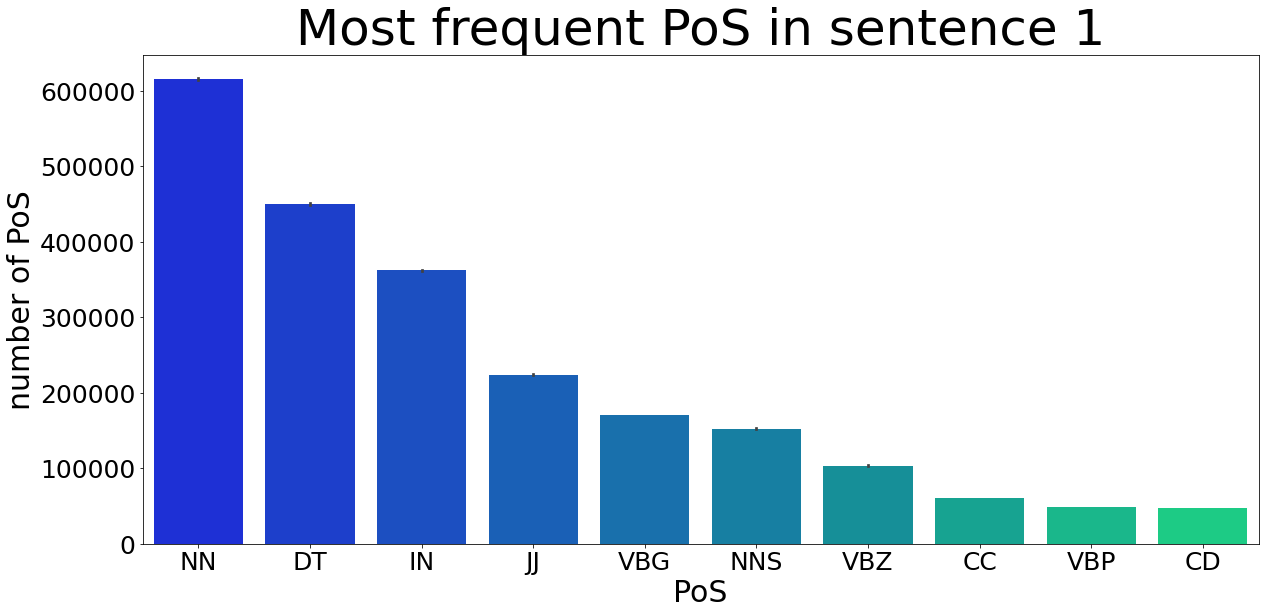

In [99]:
plt.figure(figsize=(20, 9))
ax = sns.barplot(x="pos", y="total", data=df_1, palette='winter')
ax.set_xlabel("PoS",fontsize=30)
ax.set_ylabel("number of PoS",fontsize=30)
ax.tick_params(labelsize=25)
plt.title('Most frequent PoS in sentence 1', fontsize=50);


In [100]:
pos_2 = {'label': [], 'pos': [], 'total': []}
for label in ['contradiction', 'entailment', 'neutral']:
    for word in sent2_pos.index:
        pos_2['label'].append(label)
        pos_2['pos'].append(word)
        pos_2['total'].append(sent2_pos[label][word])

In [101]:
df_2 = pd.DataFrame(pos_2)

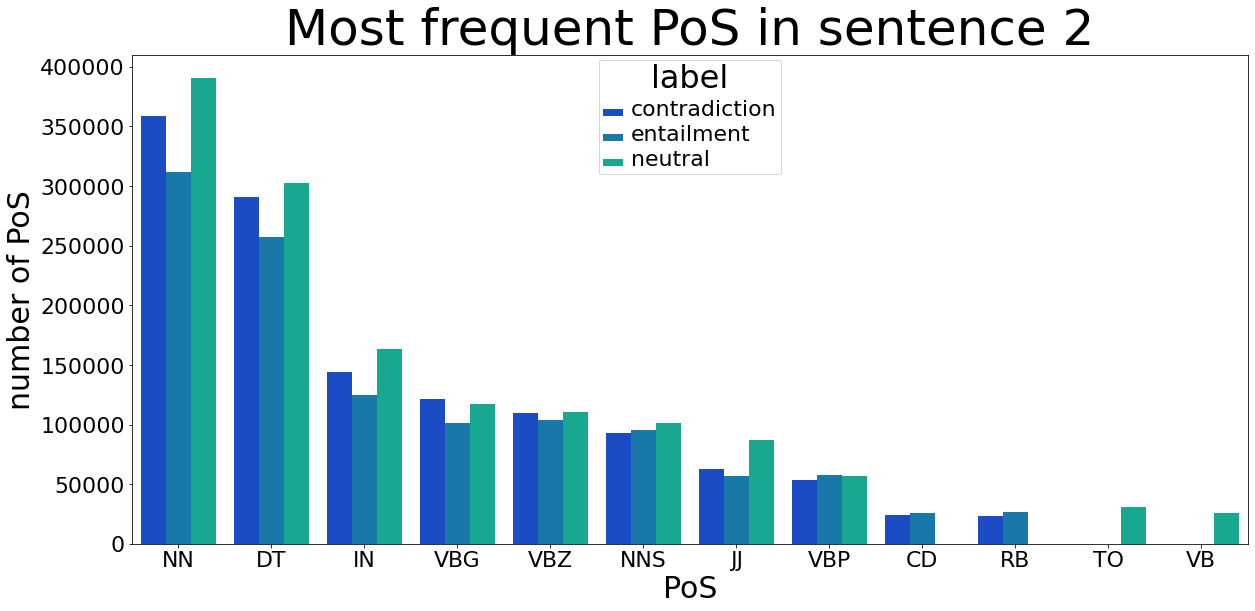

In [102]:
plt.figure(figsize=(20, 9))
ax = sns.barplot(x="pos", y="total", hue='label', data=df_2, palette='winter')
ax.set_xlabel("PoS",fontsize=30)
ax.set_ylabel("number of PoS",fontsize=30)
ax.tick_params(labelsize=22)
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
plt.title('Most frequent PoS in sentence 2', fontsize=50);